### Forecast utilizando Prophet

Esse modelo considera tendência e sazonalidade de séries não estacionárias

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objs as go
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

Importação dos dados sem transformação matemática

In [2]:
df = pd.read_csv('df.csv')
df.set_index(df.Data, inplace=True)
df.drop('Data', inplace=True, axis=1)

In [3]:
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%,ds,y
Data,,,,,,,,
2004-01-02,22.445,22.233,22.450,22.208,136420000,0.94,2004-01-02,22.445
2004-01-05,23.532,22.445,23.532,22.445,496710000,4.84,2004-01-05,23.532
2004-01-06,23.576,23.532,23.976,23.180,472380000,0.19,2004-01-06,23.576
2004-01-07,23.320,23.576,23.899,23.320,464080000,-1.09,2004-01-07,23.320
2004-01-08,23.717,23.334,23.718,23.122,436740000,1.70,2004-01-08,23.717
...,...,...,...,...,...,...,...,...
2023-08-21,114.429,115.404,115.425,114.067,9790000,-0.85,2023-08-21,114.429
2023-08-22,116.156,114.433,116.286,114.433,9830000,1.51,2023-08-22,116.156
2023-08-23,118.135,116.160,118.135,116.159,11540000,1.70,2023-08-23,118.135


Funções para cálculo dos erros

In [4]:
def mape_error(y_true, y_pred):
    n = len(y_true)
    mape = (np.abs((y_true - y_pred) / y_true).sum() / n)
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2%}")
    return mape

def wmape_error(y_true, y_pred):
    wmape = np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
    print(f"WMAPE (Weighted Mean Absolute Percentage Error): {wmape:.2%}")
    return wmape

def smape_error(y_true, y_pred):
    smape = (np.abs(y_pred - y_true) * 2 / (np.abs(y_pred) + np.abs(y_true))).mean()
    print(f"SMAPE (Symmetric Mean Absolute Percentage Error): {smape:.2%}")
    return smape

Separação de dados de treino, teste e validação

In [5]:
train = df.loc[df.ds < '2023-07-01']
test = df.loc[(df.ds >= '2023-07-01') & (df.ds < '2023-08-16')]
valid = df.loc[df.ds >= '2023-08-16']
train.loc[:, 'unique_id'] = 'Fechamento'
test.loc[:, 'unique_id'] = 'Fechamento'
valid.loc[:, 'unique_id']  = 'Fechamento'
train.drop(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], inplace=True, axis=1)
test.drop(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], inplace=True, axis=1)
h = test.index.nunique()
print(train.shape)
print(test.shape)
print(h)

(4827, 3)
(32, 3)
32


C:\Users\nycol\AppData\Local\Temp\ipykernel_25824\2436242718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, 'unique_id'] = 'Fechamento'
C:\Users\nycol\AppData\Local\Temp\ipykernel_25824\2436242718.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'unique_id'] = 'Fechamento'
C:\Users\nycol\AppData\Local\Temp\ipykernel_25824\2436242718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Treinando modelo

In [6]:
m = Prophet()
m.add_seasonality(name='weekly', period=7, fourier_order=7)
m.fit(train)
future = m.make_future_dataframe(periods=32,freq='B')

02:23:48 - cmdstanpy - INFO - Chain [1] start processing
02:23:51 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
train

,ds,y,unique_id
Data,,,
2004-01-02,2004-01-02,22.445,Fechamento
2004-01-05,2004-01-05,23.532,Fechamento
2004-01-06,2004-01-06,23.576,Fechamento
2004-01-07,2004-01-07,23.320,Fechamento
2004-01-08,2004-01-08,23.717,Fechamento
...,...,...,...
2023-06-26,2023-06-26,118.243,Fechamento
2023-06-27,2023-06-27,117.523,Fechamento
2023-06-28,2023-06-28,116.681,Fechamento


In [9]:
test.shape

(32, 3)

In [17]:
future

,ds
0,2004-01-02
1,2004-01-05
2,2004-01-06
3,2004-01-07
4,2004-01-08
...,...
4854,2023-08-09
4855,2023-08-10
4856,2023-08-11
4857,2023-08-14


In [12]:
test.tail(5)

,ds,y,unique_id
Data,,,
2023-08-09,2023-08-09,118.409,Fechamento
2023-08-10,2023-08-10,118.350,Fechamento
2023-08-11,2023-08-11,118.065,Fechamento
2023-08-14,2023-08-14,116.810,Fechamento
2023-08-15,2023-08-15,116.171,Fechamento


Previsão

In [13]:
prophet_forecast = m.predict(future)
prophet_future=prophet_forecast.tail(32)
prophet_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
4827,2023-07-03,112.234131,104.066942,119.410825
4828,2023-07-04,112.243756,103.826371,119.822008
4829,2023-07-05,112.296163,105.193469,119.893774
4830,2023-07-06,112.326023,105.243520,120.405264
4831,2023-07-07,112.381200,104.475911,119.734991
4832,2023-07-10,112.510063,105.041570,119.776165
4833,2023-07-11,112.590185,105.236691,120.141778
4834,2023-07-12,112.708437,104.987725,120.548842
4835,2023-07-13,112.798292,105.144025,120.779587
4836,2023-07-14,112.906538,104.933894,120.776193


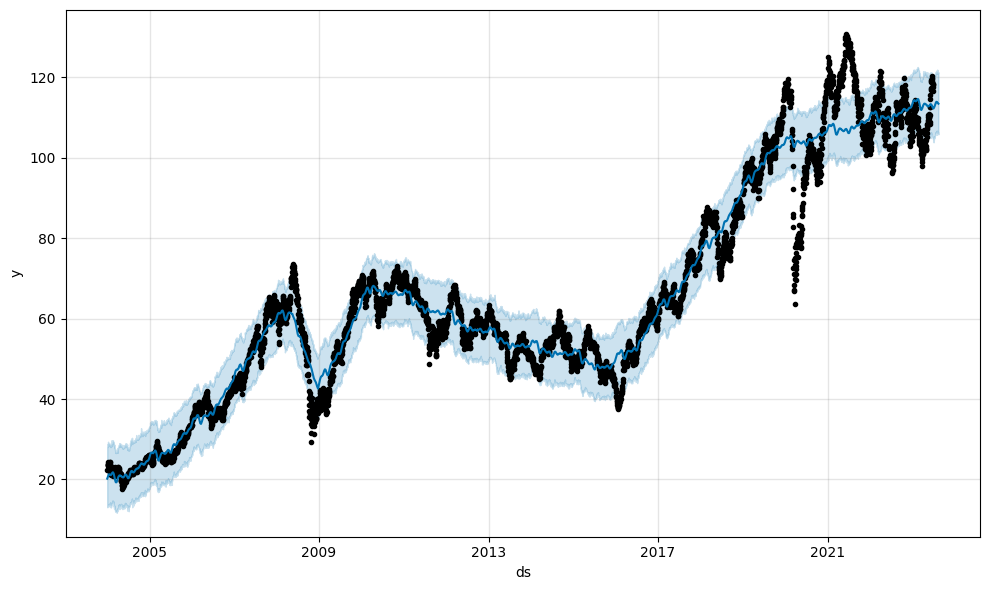

In [14]:
fig = m.plot(prophet_forecast)

In [15]:
plot_components_plotly(m, prophet_forecast)

c:\Users\nycol\OneDrive\Documentos\0 Pos Tech\Tech_2\Tech_Challenge_Fase2\venv\Lib\site-packages\plotly\io\_json.py:534: UserWarning:

Discarding nonzero nanoseconds in conversion.



Avaliação

In [16]:
model_names = ['Prophet']
mape_errors = [mape_error(test['y'].values, prophet_future['yhat'].values)]
wmape_errors = [wmape_error(test['y'].values, prophet_future['yhat'].values)]
smape_errors = [smape_error(test['y'].values, prophet_future['yhat'].values)]
df_error = pd.DataFrame({'model': model_names, 'mape': mape_errors, 'wmape': wmape_errors, 'smape': smape_errors})
df_error.to_csv('Data/ErrorsProphet.csv', index=False)

MAPE (Mean Absolute Percentage Error): 4.91%
WMAPE (Weighted Mean Absolute Percentage Error): 4.93%
SMAPE (Symmetric Mean Absolute Percentage Error): 5.04%
